<a href="https://colab.research.google.com/github/sh-biswas/demand-forecasting_Cogs109Final/blob/master/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)
%matplotlib inline

In [114]:
data = 'https://raw.githubusercontent.com/sh-biswas/demand-forecasting_Cogs109Final/master/train.csv'
data = pd.read_csv(data)

# create arrays to hold parsed year, month, and day
years = np.empty(data.shape[0]).astype('int32')
months = np.empty(data.shape[0]).astype('int32')
days = np.empty(data.shape[0]).astype('int32')
#print(f"len(years): {len(years)}")

# parse "year", "month", and "day" from 'date' string
def date_parser(row):
  #print(f"row: \n{row}")
  #print(f"row['date']: {row['date']}")
  year, month, day = tuple(row['date'].split("-"))
  #print(f"year: {year} | month: {month} | day: {day}")
  #print(f"row.name: {row.name}")
  years[row.name] = int(year); months[row.name] = month; days[row.name] = day;
  #print(years[row.name])

# call parser on all rows
data.apply(date_parser, axis=1)

# add "year", "month", and "day" columns to data
data['year'] = years
data['month'] = months
data['day'] = days


# separate out train and test data
data = data.sort_values(by = ['date'])
print(f"first test date: {data['date'].unique()[-90]}")
test = data[-45000:][data[-45000:]['item'] == 15]
train = data[:-45000][data[:-45000]['item'] == 15]
#print(f"length of train: {len(train)}")
#print(f"num train dates: {len(train['date'].unique())}")


first test date: 2017-10-03


In [115]:
print(f"THESE SHOULD BE THE SAME: \n{len(years)}\n{len(data.index)}")

THESE SHOULD BE THE SAME: 
913000
913000


In [116]:
train.head()

,date,store,item,sales,year,month,day
255640,2013-01-01,1,15,42,2013,1,1
257466,2013-01-01,2,15,65,2013,1,1
259292,2013-01-01,3,15,61,2013,1,1
261118,2013-01-01,4,15,46,2013,1,1
262944,2013-01-01,5,15,31,2013,1,1


Check if there are any null values

In [117]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
year     0
month    0
day      0
dtype: int64

In [118]:
test.isnull().sum()

date     0
store    0
item     0
sales    0
year     0
month    0
day      0
dtype: int64

There are no null values in both our test and train datasets.

How many different stores are there in the train dataset?

In [119]:
num_stores = len(data.store.unique())
print(stores)

10


How many different items in the train dataset?

In [120]:
num_items = len(train.item.unique())
print(num_items)

1


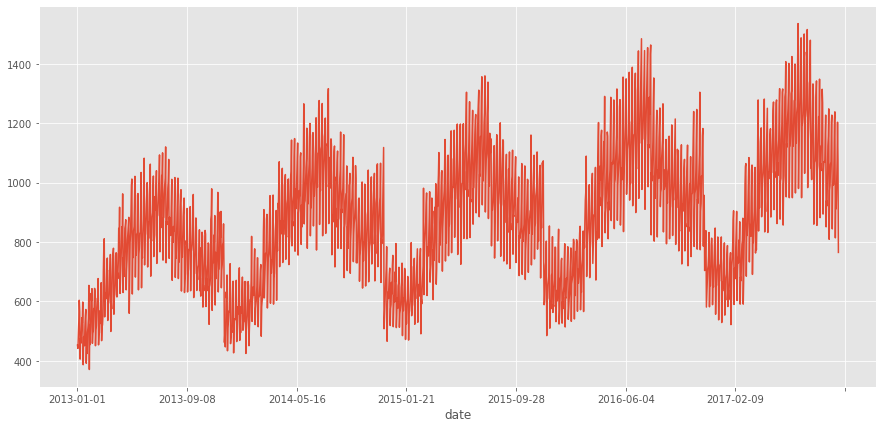

In [138]:
fig, ax = plt.subplots(figsize=(15,7))
train.groupby(['date']).sum()['sales'].plot(ax=ax)

In [132]:
np.argmax(train.groupby(['item']).sum()['sales'])

0

In [133]:
len(train.groupby(['item']).sum()['sales'])

1

In [152]:
# just for store 1 to start
train_store1 = train[ train['store'] == 1]
test_store1 = test[ test['store'] == 1]


# let's do some linear regression!
A = np.vstack((np.ones(len(train_store1)), train_store1['year'], train_store1['month'], train_store1['day'])).T
w = np.linalg.lstsq(A, train_store1['sales'], rcond=None)[0]
print(f"1st order model: {w[0]:0.2f} + {w[1]:0.2f}*year + {w[2]:0.2f}*month + {w[3]:0.2f}*day")


              date  store  item  sales  year  month  day
255640  2013-01-01      1    15     42  2013      1    1
255641  2013-01-02      1    15     33  2013      1    2
255642  2013-01-03      1    15     45  2013      1    3
255643  2013-01-04      1    15     39  2013      1    4
255644  2013-01-05      1    15     47  2013      1    5
...            ...    ...   ...    ...   ...    ...  ...
257371  2017-09-28      1    15     85  2017      9   28
257372  2017-09-29      1    15    104  2017      9   29
257373  2017-09-30      1    15    100  2017      9   30
257374  2017-10-01      1    15    104  2017     10    1
257375  2017-10-02      1    15     59  2017     10    2

[1736 rows x 7 columns]
1st order model: -13283.86 + 6.63*year + 1.32*month + -0.02*day


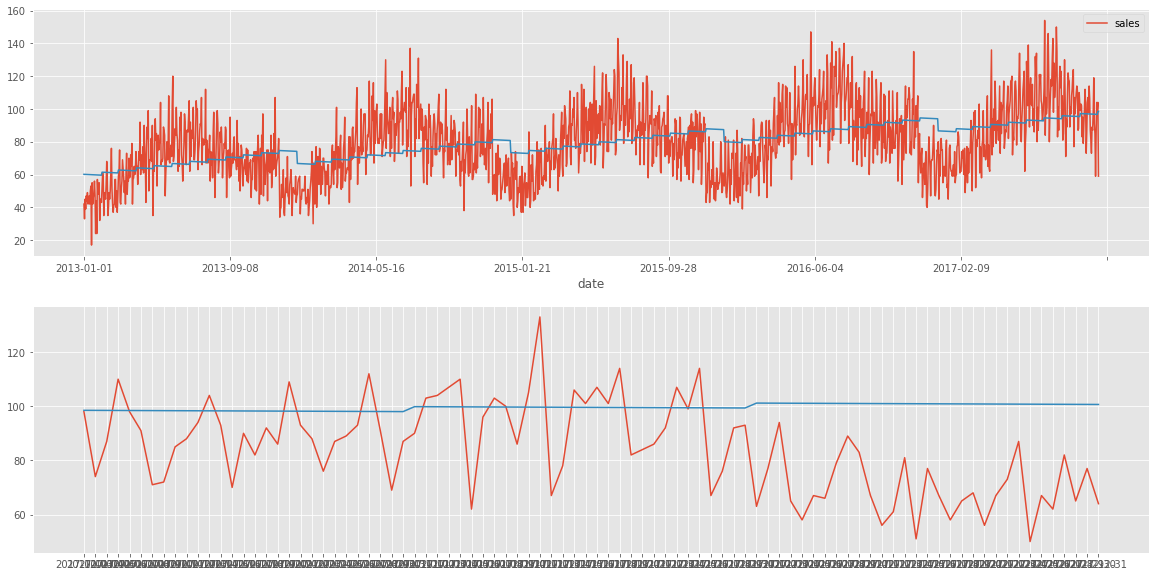

In [151]:
fig, axs = plt.subplots(2,1)
train_store1.plot(x='date', y='sales', figsize=(20,10), ax=axs[0])
axs[1].plot(test_store1['date'].values, test_store1['sales'].values)

## Create a smooth set of Y values for plotting the model
modelYtest = w[0] + w[1]*test_store1['year'].values + w[2]*test_store1['month'].values + w[3]*test_store1['day'].values
modelYtrain = w[0] + w[1]*train_store1['year'].values + w[2]*train_store1['month'].values + w[3]*train_store1['day'].values
axs[1].plot(test_store1['date'].values, modelYtest)
axs[0].plot(train_store1['date'].values, modelYtrain)


Model each item individually for all the stores -> supplier knows how many of each item to distribute over the time span of the test data(supplier perspective)